# Lecture 22: Neural Networks


Applied Machine Learning 


Professor: __Ramesh Natarajan__ \
Email: **ramesh.natarajan@yu.edu** \
Department of Computer Science \
Stern College and Yeshiva University

Date: Apr xx, 2024



In [2]:
print(pydot.__version__)

NameError: name 'pydot' is not defined

## Acknowledgements

1. The starting point for developing the notebook-based instruction material was the set of notebooks provided by the previous  course instructor__[Prof. Zach Glassman](https://www.linkedin.com/in/zachary-glassman-7088844b/)__.
2. These notebooks have been augmented by similar instruction material taken from many, many other sources, including official documentation from many ML libraries and frameworks. I have adapted and modified the content where needed to make it compatible with student level, orientation and proficiency in this course.
3. The primary addition sources include:
   1. Course content from V. Kuleshov, Cornell Tech __[repo](https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/blob/main/notebooks/lecture1-introduction.ipynb)__.
   2. Book and support material from Hal Daume II, __[A course in Machine Learning](http://ciml.info)__. __[repo](https://github.com/hal3/ciml/)__
   3. Book and support material from A. Geron, __[Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (3rd edition)](https://homl.info/er3)__. __[repo](https://github.com/ageron/handson-ml3/blob/main/README.md)__





# Neural Networks  


<table>
    <td width="40%"><center>
        <img src="./img/Lecture-22/neural-networks-creative.png" />      
    </center>
    Generated by Chat-GPT 
     </td>  
    <td>
<font size = "+1.2">
 
Neural Networks are flexible and composable  architechtures for supervised learning.  Most of the recent advances in Machine Learning and some especially signicant improvements in image, video, speech and text classification have been obtained by scaling small neural networks to what are known as deep learning networks (covered in the next lecture).   Several important frameworks such as Pytorch, Tensorflow and Jax have been developed for implementing neural network model training and inference. 


</td></table> 


# Background

Neural Networks is one of the most important algorithms for Machine Learning and is used in many applications from advanced NLP systems, search engines, medical applications such as radiology, speech, vision and video recognition, recommendation engines etc.

At its core, deep learning is about building connected layers of simple linear models AND adding non-linear transformations between the layers.   The resulting model architecture is very well suited for many applications. 

The following code plots a  two-layer neural network which takes a 2-dimensional feature in the input layer $x_0, x_1$ and passes it through two hidden layers $h_1, h_2$ which respectively have 4 and 2 nodes, and an output layer that predicts the target $y$.

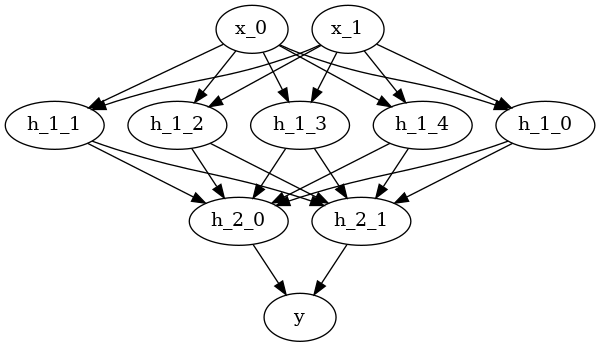

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import pydot
from IPython.display import Image, display

def create_image(graph):
    return display(Image(graph.create_png()))

def plot_dense_nn(layers, label_edges=False):
    dot = pydot.Dot()
    def _gen_label(i, j):
        if i == 0:
            return f'x_{j}'  
        elif i == len(layers) -1:
            return 'y'
        return f"h_{i}_{j}"
    for i, layer in enumerate(layers):
        for j in range(layer):
            node_key = f"{i}_{j}"
            dot.add_node(pydot.Node(node_key, label=_gen_label(i, j)))
            if i > 0:
                for prev_node in range(layers[i-1]):
                    label = '' if not label_edges else f'w_{i};{prev_node}_{j}'
                    dot.add_edge(
                        pydot.Edge(f"{i-1}_{prev_node}", node_key, label=label)
                    )
    
    return create_image(dot)

plot_dense_nn([2, 5, 2, 1], label_edges = False)

This is known as a two-layer network (input and output layers are excluded and only hidden layers are counted)

The nodes $h_{ij}$ are known as hidden units (neurons) which are organized in layers.  

Each edge in the network represents a connection between neurons and has a corresponding weight. 

The products of the incoming edge weights and the incoming values (excitations) are summed up at each neuron, and an activation function is applied.   The result is passed down the network as the corresponding neuron excitation 

This example has a single hidden layer and a single output neuron.  It is in fact identical to the perceptron, and the perceptron learning process could be used to learn optimal values for the weights.

## How we do predict the output?


1. The inputs are all summed up with each input being the value of the previous neuron times the weight of the connection.  Then you compute the activation using an activation function.
2. Percolate this through the layers until you get a final output.

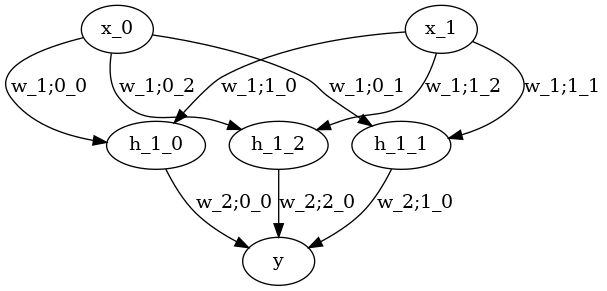

In [3]:
plot_dense_nn([2, 3, 1], label_edges=True)

Lets compute using an activation function $\sigma$.  

$$h_{1,0} = \sigma( w_{1;0,0} x_0  +  w_{1; 0, 1} x_1 )$$
$$h_{1,1} = \sigma( w_{1;1,0} x_0  +  w_{1; 1, 1} x_1 )$$

This computation of the network result is sometimes called *forward propagation*

## The activation function

The choice of activation is very important, however, one requirement is that it MUST be non-linear.

One obvious choice is the *sign* function, but in practice a function like hyperbolic tangent is more commonly used.  
Why are these more useful?

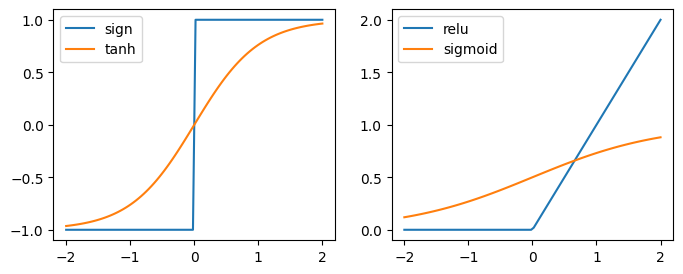

In [4]:
import numpy as np
x = np.linspace(-2, 2, 100)
fig, ax = plt.subplots(1, 2, figsize = (8,3))
ax[0].plot(x, np.sign(x), label='sign')
ax[0].plot(x, np.tanh(x), label='tanh')
ax[0].legend()

ax[1].plot(x, x * (x > 0), label = 'relu')
ax[1].plot(x, 1.0/(1.0 + np.exp(-x)), label = 'sigmoid')
ax[1].legend()

plt.show()

## Two layer network

Let $\sigma$ denote the  activation function, we can write the entire two layer $[2, 3, 1]$ network as 

$$ h_1 =  \sigma(W_1 x), \quad h_2 = \sigma( W_2 h_1), \quad  y = W_3 h_2$$

where $W_1$ is $2\times 3$,  $W_2$ is a $3\times 2$ and $ W_3$ is $2 \times 1$.

Note that a bias term for each node can also be easily added to this neural network model. 

Is this more powerful than a single layer?  In other words, does our "deep" learning get us anywhere?

### Revisiting the XOR problem (again)

Lets try the XOR problem with a perceptron, what do we know will happen?

Lets start by setting up some blobs of points with the XOR problem.

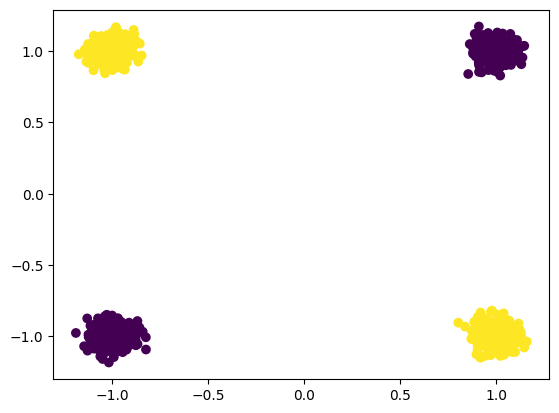

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[
    [1, 1],
    [1, -1],
    [-1, 1],
    [-1, -1]
], cluster_std=.06)
y = ((np.sign(X[:, 0]) != np.sign(X[:, 1])).astype(int) - .5) * 2

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Now lets train a perceptron as best as we can (even though we know it won't do very well) as it can only learn linear decision boundaries.

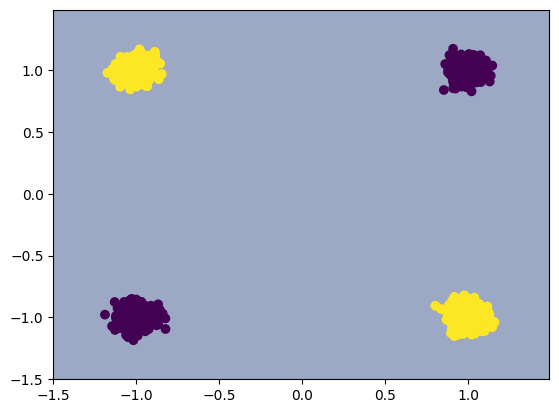

In [6]:
from sklearn.linear_model import Perceptron
p_model = Perceptron().fit(X, y)
xx, yy = np.meshgrid(np.arange(-1.5, 1.5, .01), np.arange(-1.5, 1.5, .01))
zz = p_model.predict(np.c_[xx.ravel(), yy.ravel()])
plt.contourf(xx, yy, zz.reshape(xx.shape), alpha=.5)
plt.scatter(X[:, 0], X[:, 1], c=y)

Now we can try the same with a neural network.  Although we won't typically use `scikit-learn` for neural networks, we can use the Multi Layer Perceptron for this example as a very simple example of the type of neural network we have discussed.

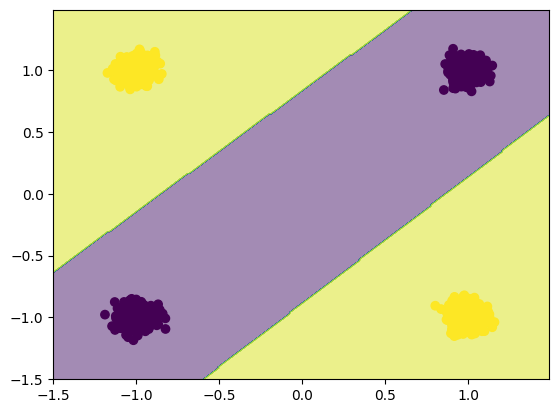

In [28]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(2), max_iter=10000)
model.fit(X, y)

xx, yy = np.meshgrid(np.arange(-1.5, 1.5, .01), np.arange(-1.5, 1.5, .01))
zz = model.predict(np.c_[xx.ravel(), yy.ravel()])
plt.contourf(xx, yy, zz.reshape(xx.shape), alpha=.5)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

It turns out that even with only two layers and nonlinear activation functions,  we can approximate fairly arbitrary classification functions.  However, to do this, we may need a large number of hidden units.

If we have $K$ hidden layers with $n_k$ in the $k$'th layer, and if  $d$ is the input dimension, then the total number of parameters is givne by 

$$ n_0d + \sum_{k=1}^{K-1} n_{k-1} n_k + n_k$$


Therefore it is easy to overfit neural network models, and  we need lots of data for training. 

# Training Neural Network Models


The process is not different from that for other models

1. Define a loss function in terms of the neural network weights
2. Perform gradient descent  
3. Repeat until the weights have "converged"


Naively compute the partial derivatives (gradients) of the loss function with respect to the weights would very expensive given the large number of examples and weights.  However the neural network structure allows for all the gradients to be computed inexpensively in a single  pass over the training data, with just an forward and backwards traversal of the neural network graph.   Typically multiple examples are batched together to make this forwards and backwards traversal even more efficient.

This special algorithm is known as backpropagation.



## Backpropagation

- You can think of backpropagation as a very fancy application of the chain rule of differentiation.
- The idea is that we are propagation the "error" backwards through the network
- By techniques of autodifferentation (reverse mode automatic differentiation) we can do this extremely efficiently

*Note*: Automatic differentiation is REALLY cool.  It provides effectively exact answers (to numerical precision) really quickly.  

For a good discussion of automatic differention, see 
[here](https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6)

We will revisit backprop in more detail in later lectures, but for now, key takeaways:

1. The network gradients needed are computed in basically two passes of the network
2. Given the local gradients, I can then perform a gradient descent to optimize the network.
3. Libraries have very efficient implementations of this, you will not need to do it yourself

We are now going to learn the basics of building a network, we will revisit some of the fundamental contexts as we are building.

# Advanced Machine Learning Frameworks


There are a few different libraries which are used for production machine learning, the most popular are

- tensorflow
- pytorch

On top of these libraries there are many different interfaces,

- keras
- flair
- pytorch lightening
- hugging face
- on and on (deep learning is REALLY popular right now!)

We will focus on Keras using the tensorflow backend which offers a good mix of robust production quality code as well as being relatively easy to use.

Keras can be considered an API for deep learning models much in the same way as sklearn is an API for regular machine learning.

Tensorflow subsumes Keras and provides many additonal utitities for data handling, preprocessing, model visualization, model metrics and monitoring. 

### Why "tensor"flow?

- Tensors are mathematical objects (similar to numpy arrays but customized for ML applications). 
- Tensorflow is a library to very efficiently handle and compute with tensors with a lot of built-in functionality for deep learning 

In [10]:
%%capture
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


2024-04-12 14:43:53.210460: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 14:43:53.219181: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 14:43:53.283407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:43:54.286283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Lets start with a simple dataset consisting of images which show different types of objects we might buy.

In [11]:
_data = tf.keras.datasets.fashion_mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = _data

In [12]:
# taken from https://github.com/zalandoresearch/fashion-mnist
labels = {0: 'T-shirt/top',
    1: 'Trouser',2: 'Pullover',3: 'Dress',4: 'Coat',5: 'Sandal',6: 'Shirt',7: 'Sneaker',8: 'Bag',9: 'Ankle boot'
}

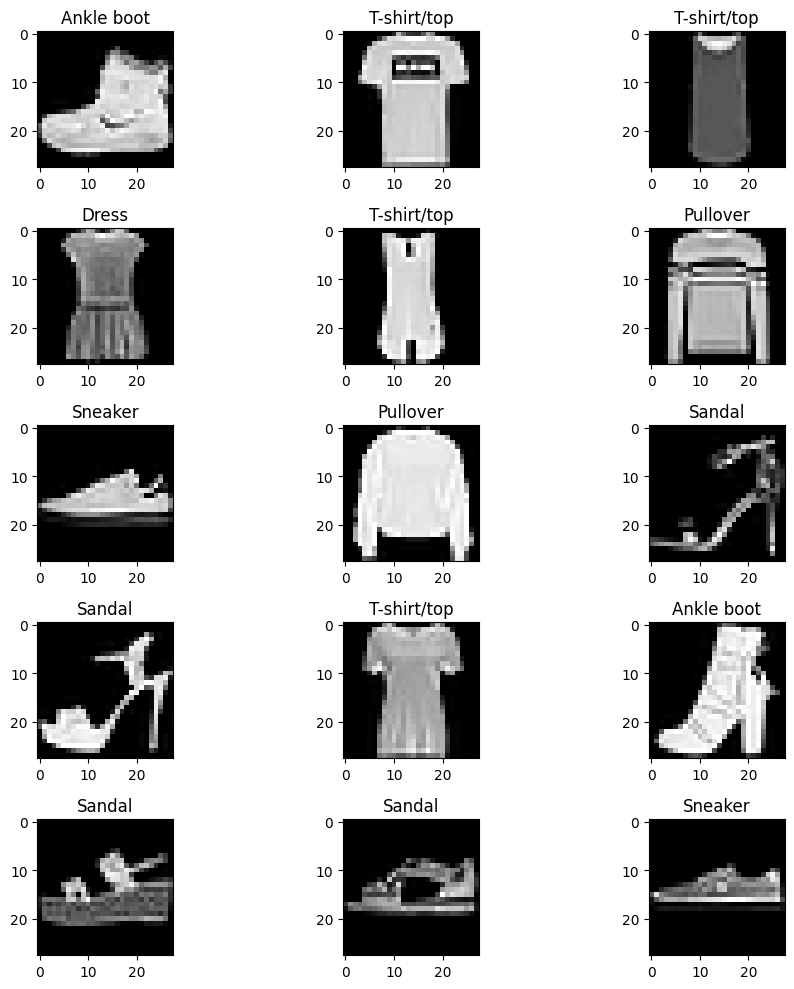

In [13]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i, ax_ in enumerate(ax.ravel()):
    ax_.imshow(train_images[i], cmap=plt.cm.gray)
    ax_.set_title(labels[train_labels[i]])
plt.tight_layout()

We will now create a very simple model.  `keras` offers a nice API which allows us to build up our model in layers exactly how we would visualize it (we will see how to visualize it in code as well!)

We start by creating a `tf.keras.Sequential` class which is our model.  We can then add the layers we need to the model.

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(140, activation='relu'))
model.add(tf.keras.layers.Dense(10))

/opt/tljh/user/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We then need to "compile" our model.  this is where set things like

- Optimizer want to use
- loss function
- metrics we want to store
- etc

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Similiar to `scikit-learn` we can then fit our model, however, we can pass a few more arguments here, the most important for now is `epochs`

An *epoch* is the number of times the training algorithm will pass over the entire dataset and perform the optimization.

In [16]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6699 - loss: 9.7348
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7667 - loss: 0.6853
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8086 - loss: 0.5481
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8161 - loss: 0.5312
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8194 - loss: 0.5154
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8188 - loss: 0.5174
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8223 - loss: 0.5059
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8279 - loss: 0.4824
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8252 - loss: 0.4894
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8307 - loss: 0.4809


We can then evaluate the results on the test set using the `evaluate` method of the model.

In [17]:
model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8342 - loss: 0.5697


[0.590527355670929, 0.8277000188827515]

As we train, it can be useful to see the results, this is where tensorboard can really help.

In [ ]:
from pathlib import Path
from datetime import datetime
import os


def do_train(epochs):
    logdir = os.path.join("logs",datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    return model.fit(
        x=train_images, y=train_labels, epochs=epochs,
        validation_data=(test_images, test_labels),
        callbacks=[tensorboard_callback]
    )

do_train(10)

In [1]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs --bind_all